<a href="https://colab.research.google.com/github/kelangray/Neural-ODEs/blob/main/hnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from torchdyn.core import NeuralODE
from torchdyn.models import HNN

# Hamiltonian Neural Networks

The Neural ODE framework can be used to incorporate physical priors into the learning process.One way to encode physical priors into the model is by looking at the Hamiltonian.

Using canonical coordinates $(q, p)$, where $q \in \mathbb{R}^d$ represents position and $p \in \mathbb{R}^d$represents momentum, the system's total energy is encoded by the Hamiltonian $\mathcal{H}: \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$. The dynamics follow Hamilton's equations:

$$
\dot{q} = \nabla_p \mathcal{H}, \quad \dot{p} = -\nabla_q \mathcal{H}.
$$

We parameterize $\mathcal{H}$ using a neural network $\mathcal{H}_\theta(p, q)$, forming a system of neural ODEs. Training involves minimizing the loss function:

$$
\mathcal{C}(\theta) = \left\| \dot{q} - \nabla_p \mathcal{H}_\theta \right\|_2^2 + \left\| \dot{p} + \nabla_q \mathcal{H}_\theta \right\|_2^2,
$$

which enforces the Hamiltonian structure and conserves energy. We can then train using the TorchDyn library:


> Poli, M., Massaroli, S., Yamashita, A., Asama, H., Park, J., & Ermon, S. (2021). [TorchDyn: Implicit Models and Neural Numerical Methods in PyTorch](https://physical-reasoning.github.io/assets/pdf/papers/03.pdf).

Hamiltonian Neural Networks (HNNs) were introduced by Greydanus et al. See their paper:

> Greydanus, S., Dzamba, M., & Foster, D. (2019). [Hamiltonian Neural Networks](https://arxiv.org/pdf/1906.01563).






### Generate Mass-Spring Training Data

Consider a simple 1D mass-spring system as an example. Let $ q = X $ represent the displacement and $ p = \dot{X} $ represent the velocity. The equation of motion is given by:

$$
m \ddot{X} - kX = 0, \quad X(0) = 0, \quad \dot{X}(0) = 2 \pi,
$$

where $ m $ is the mass, and $ k $ is the spring constant.

Assume:
- $ m = 1 $,
- The angular frequency of the system is $ \omega = 1 $,

then the spring constant $k$ is determined as $ k = \omega^2 = 1 $. The true solution to the system is:

$
X(t) =\sin(t), \quad \dot{X}(t) = \cos(t).
$

Let's add some noise to this ideal solution.


In [6]:
device = torch.device("cpu")

#Generate Training Data
t = torch.linspace(0, 2*np.pi, 50).reshape(-1, 1).to(device)
omega = 1 #Frequency

#(q, p) pairs
X = torch.cat([
    torch.sin(omega * t),
    omega*torch.cos(omega* t)
], 1).to(device)

#(dq/dt, dp/dt) pairs
y = torch.cat([
    omega*torch.cos(omega * t),
    -(omega**2)*torch.sin(omega* t)
], 1).to(device)

#Add Gaussian noise to data
noise_level = 0.1
noise_X = noise_level * torch.randn_like(X)
X_noisy = X + noise_X

train = data.TensorDataset(X_noisy, y)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

###Visualize Training Data


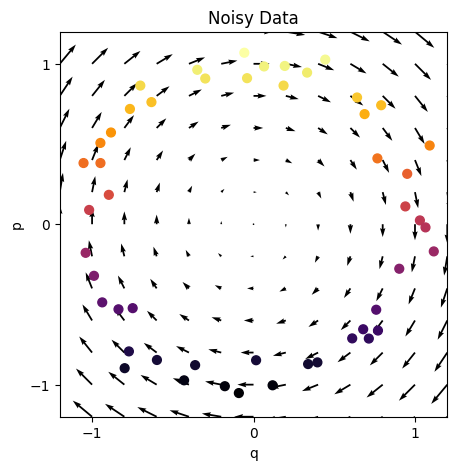

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

# Ground truth vector field
X, Y = np.meshgrid(np.arange(-1.2, 1.3, 0.2), np.arange(-1.2, 1.3, 0.2))  # Adjust meshgrid for range
U = Y
V = -X
ax.quiver(X, Y, U, V, scale=10, scale_units='xy', color='k')  # Adjust scale for better visualization

#Noisy Observations
ax.scatter(X_noisy[:, 0], X_noisy[:, 1], c=X_noisy[:, 1], cmap="inferno", s=40)
ax.set_xlim(-1.2, 1.2), ax.set_ylim(-1.2, 1.2), ax.set_xticks([-1, 0, 1]), ax.set_yticks([-1, 0, 1])
ax.set_xlabel("q")
ax.set_ylabel("p")
ax.set_title("Noisy Data")

plt.show()

##Define Hamiltonian Neural Network

In [8]:
#Wrapper class to define HNN
class HNN(nn.Module):
    def __init__(self, Hamiltonian:nn.Module, dim=1):
        super().__init__()
        self.H = Hamiltonian
        self.n = dim
    def forward(self, x):
        with torch.set_grad_enabled(True):
            x = x.requires_grad_(True)
            gradH = torch.autograd.grad(self.H(x).sum(), x, allow_unused=False, create_graph=True)[0]

        # Concatenate derivatives:
        # dq/dt = ∂H/∂p (position update)
        # dp/dt = -∂H/∂q (momentum update)
        return torch.cat([gradH[:,self.n:], -gradH[:,:self.n]], 1).to(x)

# Instantiate the Hamiltonian function
H = HNN(nn.Sequential(
            nn.Linear(2,64),
            nn.Tanh(),
            nn.Linear(64,1))).to(device)

# Wrap the HNN in a NeuralODE module
model = NeuralODE(H, sensitivity='adjoint', solver='dopri5').to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [9]:
# Define the optimizer
optimizer = optim.Adam(H.parameters(), lr=0.02)

# Define the loss function (MSE in this case)
def loss_fn(y, y_hat):
    return ((y - y_hat) ** 2).mean()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch_idx, (x_batch, y_batch) in enumerate(trainloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        t_eval, y_hat = model(x_batch)
        y_hat = y_hat[1]

        loss = loss_fn(y_batch, y_hat)

        loss.backward()
        optimizer.step()

    if epoch%10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/100], Loss: 1.1047953367233276
Epoch [11/100], Loss: 0.31681472063064575
Epoch [21/100], Loss: 0.1280708909034729
Epoch [31/100], Loss: 0.028516048565506935
Epoch [41/100], Loss: 0.0171631071716547
Epoch [51/100], Loss: 0.014171311631798744
Epoch [61/100], Loss: 0.011303943581879139
Epoch [71/100], Loss: 0.01037297397851944
Epoch [81/100], Loss: 0.010018016211688519
Epoch [91/100], Loss: 0.009814925491809845


## Define Baseline Neural Network

In [10]:
#Baseline Neural Network
baseline_model = nn.Sequential(
    nn.Linear(2, 64),
    nn.Tanh(),
    nn.Linear(64, 2)
).to(device)

optimizer = optim.Adam(baseline_model.parameters(), lr=0.02)

def loss_fn(y, y_hat):
    return ((y - y_hat) ** 2).mean()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch_idx, (x_batch, y_batch) in enumerate(trainloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_hat = baseline_model(x_batch)

        loss = loss_fn(y_batch, y_hat)

        loss.backward()
        optimizer.step()

    if epoch%10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/100], Loss: 0.539121150970459
Epoch [11/100], Loss: 0.00976761057972908
Epoch [21/100], Loss: 0.007964001968502998
Epoch [31/100], Loss: 0.006211018655449152
Epoch [41/100], Loss: 0.006104645784944296
Epoch [51/100], Loss: 0.005907479673624039
Epoch [61/100], Loss: 0.005851103458553553
Epoch [71/100], Loss: 0.005833778530359268
Epoch [81/100], Loss: 0.005798239726573229
Epoch [91/100], Loss: 0.005750606767833233


###Generate Trajectories for a random initial condition





In [11]:
#Initial Condition
X_t = torch.randn(1, 2).to(device)

#HNN trajectories
t_span = torch.linspace(0, 10, 100)
hnn_traj = model.trajectory(X_t, t_span).detach().cpu()

In [12]:
num_steps = len(t_span) - 1
dt = t_span[1] - t_span[0]
traj = [X_t.detach().cpu().numpy()]  # Store initial condition

# Generate trajectories by iteratively predicting
current_state = X_t
for _ in range(num_steps):
    # Predict the change (velocity) using the baseline model
    delta_state = baseline_model(current_state)

    #Euler's method
    current_state = current_state + dt * delta_state

    traj.append(current_state.detach().cpu().numpy())
baseline_traj = np.stack(traj, axis=0)

###Calculate the total energy of each model over time

The total energy of the system over time is given by

$$E = (KE) + (PE) = \frac{1}{2}m (\dot{X})^2 + \frac{1}{2}k X^2$$

In [13]:
def energies(X_t, t_span, omega, hnn_traj, baseline_traj):
    # Compute true position and velocity
    pos = X_t.detach()[0][0] * np.cos(omega * t_span) + X_t.detach()[0][1] / omega * np.sin(omega * t_span)
    vel = -X_t.detach()[0][0] * omega * np.sin(omega * t_span) + X_t.detach()[0][1] * np.cos(omega * t_span)

    # Compute true energy
    true_energy = 0.5 * vel**2 + 0.5 * (omega**2) * pos**2

    # Compute HNN and baseline energies
    hnn_energy = []
    baseline_energy = []

    for i in range(len(X_t)):
        # HNN energy
        hnn_p = hnn_traj[:, i, 0]
        hnn_v = hnn_traj[:, i, 1]
        hnn_E = 0.5 * (omega**2) * hnn_p**2 + 0.5 * hnn_v**2
        hnn_energy.append(hnn_E)

        # Baseline energy
        baseline_p = baseline_traj[:, i, 0]
        baseline_v = baseline_traj[:, i, 1]
        baseline_E = 0.5 * (omega**2) * baseline_p**2 + 0.5 * baseline_v**2
        baseline_energy.append(baseline_E)
    return true_energy, hnn_energy[0], baseline_energy[0]

###Plot our results

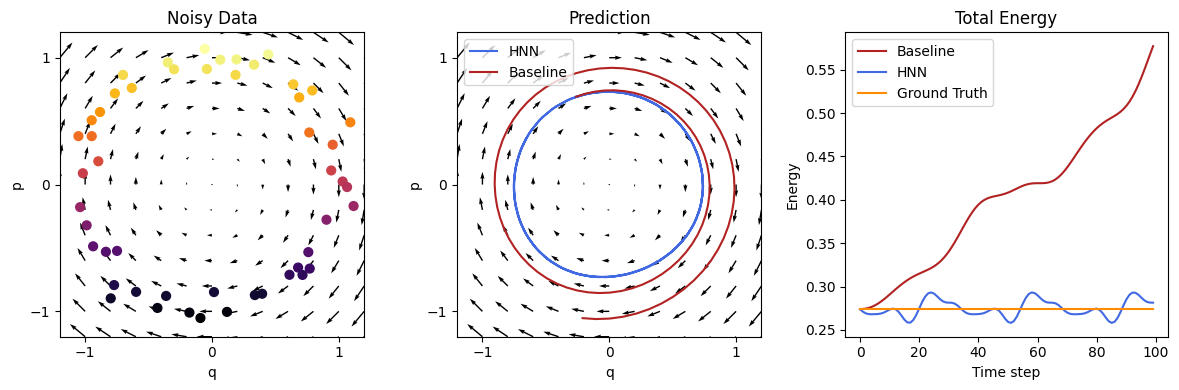

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

#Ground truth and noisy observations
axes[0].quiver(X, Y, U, V, scale=10, scale_units='xy')
axes[0].scatter(X_noisy[:, 0], X_noisy[:, 1], c=X_noisy[:, 1], cmap='inferno', label="Noisy Observations", s=40)
axes[0].set_xlim(-1.2, 1.2)
axes[0].set_ylim(-1.2, 1.2)
axes[0].set_xticks([-1, 0, 1])
axes[0].set_yticks([-1, 0, 1])
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlabel("q")
axes[0].set_ylabel("p")
axes[0].set_title("Noisy Data")

#Trajectories of each model
for i in range(len(hnn_traj[0])):
    axes[1].plot(hnn_traj[:, i, 0], hnn_traj[:, i, 1], color='royalblue', label='HNN' if i == 0 else "")
    axes[1].plot(baseline_traj[:, i, 0], baseline_traj[:, i, 1], color='firebrick', label='Baseline' if i == 0 else "")

axes[1].quiver(X, Y, U, V, scale=10, scale_units='xy')
axes[1].set_xlim(-1.2, 1.2)
axes[1].set_ylim(-1.2, 1.2)
axes[1].set_xticks([-1, 0, 1])
axes[1].set_yticks([-1, 0, 1])  #
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_title("Prediction")
axes[1].set_xlabel("q")
axes[1].set_ylabel("p")
axes[1].legend(loc='upper left')

#Energy of each model
true_E, hnn_E, baseline_E = energies(X_t, t_span, omega, hnn_traj, baseline_traj)
axes[2].plot(baseline_E, label='Baseline', color='firebrick')
axes[2].plot(hnn_E, label='HNN',  color='royalblue')
axes[2].plot(true_E, label='Ground Truth',  color='darkorange')
axes[2].set_title("Total Energy")
axes[2].set_xlabel("Time step")
axes[2].set_ylabel("Energy")
axes[2].legend()

plt.tight_layout()
plt.show()